*  This program computes 
*    the optimal portfolio with n>1 risky asset and 1 risk-free asset 
*     Here we use the 25 Fama-French port and compare the result with investing mkt 
*  it differs from the L3_Allocation25.ipynb by impoising followin portfolio weights:
*
*                           a_1 <= w_1 <= b_1,
*                           a_2 <= w_2 <= b_2,
*                        ........................
*                           a_25 <= w_25 <= b_25
*                                                 

In [10]:
import pandas as pd                     # To load data, we use the package pandas
import numpy as np
import matplotlib.pyplot as plt

import cvxopt                 # install it first by running: "pip install cvxopt" via Spyder
from cvxopt import matrix, solvers
 
%matplotlib inline

# Load the data 

df = pd.read_excel('Factors_July26_July11.xlsx')        # It has 5 columns:  date, mkt, size, b/m, riskree rate
                                                    # downloaded from Ken French's website
df2 = pd.read_excel('FF25_July26_July11.xlsx')       # return on 25 FF portfolios from Ken French's web

mkt = df.loc[:,"mkt"]/100                       # Mkt excess return;  divided by 100 due to data are in %
rf = df.loc[:,"rate"]/100

R1 = df2.loc[:,'FF1' : 'FF25']/100        # extract the 25 returns, R1 is T by 25. 

R1 = np.array(R1)                         # convert list to array to apply np.functions
rf = np.array(rf)                         # convert list to array to apply np.functions
T = len(df)                               # The number of obs
Re = np.ones((T,25))                           # creat storage for excess returns

for i in range(25):
    Re[:,i] = R1[:,i] - rf                # the excess return:  each indu substracts riskfree rate, Re[:,i]-rf

mu5 = np.mean(Re, axis = 0)              # the mean taking each column of the matrix, a row vector of 25
mu5 = mu5.T                              # make it a column vector
V5 = np.cov(Re.T)                        # the covariance estimate, 25 by 25 

VI = np.linalg.inv(V5)                     # The inverse of V

# The optimal weights on the 5 risky aasets

gamma = 3                             # The risk-averse coeff.

w5 = 1/gamma*np.matmul(VI, mu5)

                        
mu = mkt.mean()                          # The expected mkt excess return
sig2 = mkt.var()                         # The var of the mkt excess return
sigma = np.sqrt(sig2)                    # Its vol

w = (1/gamma)*mu/sig2                     # The optimal weight on mkt

print('   \n')
print('Rsik avrersion and Optimal wight on the market \n')
print('        {0:.4f}  {1:.4f}  \n '.format(gamma,w))   
print('   \n')
print('The Optimal wights on the 25 assets \n')
print(w5)   
w_rf = 1 - np.dot(w5, np.ones((25,1)))
print('   \n')
print('The rest is on riskfree asset \n')
print(w_rf)  

   

Rsik avrersion and Optimal wight on the market 

        3.0000  0.6998  
 
   

The Optimal wights on the 25 assets 

[-0.5865971  -0.89082103 -0.366633    0.45161084  1.60823242 -1.18202301
  0.06694074  1.02665453  0.49808835  0.14849162 -1.2909836   0.3962927
  1.14326436  0.45186603  0.2450602   2.01804584 -1.76692265  0.07983757
  0.58006485 -0.70043943  0.63997961 -0.0797812   0.55225776 -1.38074819
 -0.36712308]
   

The rest is on riskfree asset 

[-0.29461512]


In [11]:
# Compute the the Opt Port under bound constraints 

Q = gamma * V5        # the mapping of utility paramters into quadratic programming
Q = matrix(Q)
q = -mu5
q = matrix(q)

lb = np.ones((1, 25)) * 0.0                          # lower bound
ub = np.ones((1, 25)) * 0.2                         # upper bound
h = np.append(ub, lb, axis = 1)
h = h.T
h = matrix(h)

G1 = np.eye(25)                           # identiy matrix of order 5
G2 = - np.eye(25)
G = np.append(G1, G2, axis = 0)
G = matrix(G)

solvers.options['show_progress'] = False  # this prevent print progress data
                                          # we do not really need

sol = solvers.qp(Q, q, G, h)     # Format:  solvers.qp(Q, q, G, h, A, b) 
sola = np.array(sol['x'])

print(sola.T)

sol1 = solvers.qp(Q, q)          # using the solver for the unconstrained solution
solb = np.array(sol1['x'])
print(solb.T)

[[2.30325181e-08 4.10079198e-08 1.01678063e-07 6.09802097e-07
  1.99999444e-01 5.05561572e-08 1.47673907e-07 5.62595802e-02
  5.00294795e-06 9.30973434e-07 6.66744072e-08 9.79032716e-07
  1.99999341e-01 1.99999097e-01 4.70166378e-07 3.43204142e-07
  2.08983573e-07 8.75592316e-07 5.10651201e-06 1.29845416e-07
  4.90643381e-07 6.86044225e-07 3.76600370e-07 1.11704020e-07
  1.75100468e-08]]
[[-0.5865971  -0.89082103 -0.366633    0.45161084  1.60823242 -1.18202301
   0.06694074  1.02665453  0.49808835  0.14849162 -1.2909836   0.3962927
   1.14326436  0.45186603  0.2450602   2.01804584 -1.76692265  0.07983757
   0.58006485 -0.70043943  0.63997961 -0.0797812   0.55225776 -1.38074819
  -0.36712308]]


In [12]:
# Compute the the Opt Port under bound constraints & weights sum to 1

A = np.ones((1,25),np.float64)        # make sure it is float, not integer
A = matrix(A)
b = 1.0
b = matrix(b)

sol = solvers.qp(Q, q, G, h,A,b)     # Format:  solvers.qp(Q, q, G, h, A, b) 
solc = np.array(sol['x'])

print(solc.T)

c = np.dot(A,solc)   # double check the weights sum to 1

print(c)

[[5.66204247e-09 8.75520765e-09 1.72769049e-08 5.17749279e-08
  1.91261088e-01 1.08686731e-08 2.80220978e-08 8.73576697e-02
  3.88086027e-07 5.70595355e-08 1.33305079e-08 1.07645273e-06
  1.99999740e-01 1.99999675e-01 4.90446184e-08 1.68166868e-07
  6.23862567e-08 2.43038966e-06 3.58690735e-06 1.95811540e-08
  1.21371532e-01 1.99998958e-01 3.33465213e-06 2.30280792e-08
  4.96229343e-09]]
[[1.]]


In [13]:
# Compute the Sharpe Ratio of the Opt Port and Mkt

w5 = np.array((sola))

w5.shape = (1,25)

Port=np.ones((T,1))             # define this T vector to store the returns on the portfolio

Port[0] = np.dot(w5,Re[0]) + rf[0]      # return in the first period 

for t in range(T):
    Port[t] = np.dot(w5,Re[t]) + rf[t]  

ExPort = Port - rf                       # excess return of the optimla portfolio
muP = ExPort.mean()
sig2P = ExPort.var()
sigP = np.sqrt(sig2P)
SharpeP = np.sqrt(12)*muP/sigP

# For the mkt
 
Sharpe = np.sqrt(12)*mu/sigma

print('The Annualized Sharpe ratios of the Opt Port and Mkt \n')
print('          {0:.4f}   {1:.4f}  \n'.format(SharpeP, Sharpe)) 

The Annualized Sharpe ratios of the Opt Port and Mkt 

          0.5201   0.3963  



In [14]:
# Compute the accu returns of the opt port and the mkt

CC_Port = np.ones((T,))          # to store the accumulative returns   
CC = np.ones((T,))          # to store the accumulative returns 

mkt2 = mkt + rf       # Add back riskfree rate to get pure mkt return

CC_Port[0] = 1+Port[0]             # initial accu return
CC[0] = 1 + mkt2[0]                 # initial accu return

for t in range(T-1):
    CC_Port[t+1] = CC_Port[t]*(1+Port[t+1])
    CC[t+1] = CC[t]*(1+mkt2[t+1])
    
print('Terminal wealth in Opt Port and Mkt  \n')
print(CC_Port[T-1])  
print(CC[T-1])  

Terminal wealth in Opt Port and Mkt  

10581.883677347367
2540.3983705076002


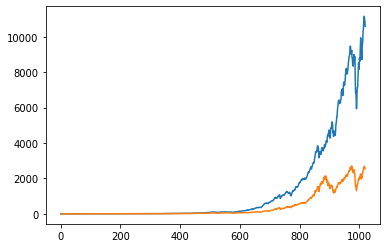

In [9]:
# plot the accu returns  

p=plt.plot(CC_Port)
p1 = plt.plot(CC)